In [1]:
## Import the libraries
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import os
import glob
import cv2
from pathlib import Path
import pandas as pd
import imgaug.augmenters as iaa
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, SeparableConv2D, GlobalMaxPooling1D

In [2]:
num_images_train_normal = len(os.listdir("data/chest_xray/train/NORMAL"))
num_images_train_pneumonia = len(os.listdir("data/chest_xray/train/PNEUMONIA"))

num_images_train_normal, num_images_train_pneumonia

(1000, 2900)

In [3]:
## Data augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1 /255.0,
                                   rotation_range = 7,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.45,
                                   shear_range = 0.2,
                                   zoom_range = 0.45,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('data/chest_xray/train/',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 interpolation = "nearest",
                                                 shuffle = True)

Found 3900 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale = 1 / 255)
test_set = test_datagen.flow_from_directory('data/chest_xray/test/',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            interpolation = "nearest",
                                            shuffle = True)

Found 1300 images belonging to 2 classes.


In [5]:
## Building the CNN 
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU(), input_shape=(64, 64, 3)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
cnn.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU()))
cnn.add(Dropout(0.1))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
cnn.add(Conv2D(64, (3, 3), strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU()))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
cnn.add(Conv2D(128, (3, 3), strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU()))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
cnn.add(Conv2D(256, (3, 3), strides = 1, padding = 'same', activation = tf.keras.layers.LeakyReLU()))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D((2, 2), strides = 2, padding = 'same'))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU()))
cnn.add(Dropout(0.2))
cnn.add(Dense(units = 1, activation = 'sigmoid'))
cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In [6]:
%time history_cnn = cnn.fit(x = training_set, validation_data = test_set, epochs = 10)

Epoch 1/10
122/122 [==============================] - 40s 314ms/step - loss: 0.9251 - accuracy: 0.7241 - val_loss: 2.3462 - val_accuracy: 0.7438
Epoch 2/10
122/122 [==============================] - 38s 311ms/step - loss: 0.4032 - accuracy: 0.8220 - val_loss: 1.2639 - val_accuracy: 0.7438
Epoch 3/10
122/122 [==============================] - 38s 313ms/step - loss: 0.3635 - accuracy: 0.8358 - val_loss: 1.7251 - val_accuracy: 0.7438
Epoch 4/10
122/122 [==============================] - 40s 330ms/step - loss: 0.3591 - accuracy: 0.8416 - val_loss: 2.1382 - val_accuracy: 0.7438
Epoch 5/10
122/122 [==============================] - 44s 360ms/step - loss: 0.3421 - accuracy: 0.8539 - val_loss: 0.8819 - val_accuracy: 0.6631
Epoch 6/10
122/122 [==============================] - 46s 374ms/step - loss: 0.3093 - accuracy: 0.8677 - val_loss: 1.2104 - val_accuracy: 0.7500
Epoch 7/10
122/122 [==============================] - 45s 372ms/step - loss: 0.3210 - accuracy: 0.8582 - val_loss: 3.4865 - val_ac

In [7]:
test_image = image.load_img(
    'data/chest_xray/val/PNEUMONIA/person128_virus_261.jpeg', target_size=(64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = cnn.predict(test_image)
# training_set.class_indices
if result[0][0] == 1:
    prediction = 'Pneumonia'
else:
    prediction = 'Normal'
print(prediction)

Pneumonia


In [8]:
data_dir = Path('data/chest_xray')

train_dir = data_dir / 'train'

val_dir = data_dir / 'test'

normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

In [9]:
## Loading the validation data as numpy array
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []


for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64, 64))
    
    img = img.astype(np.float32)/255.
    label = 0
    valid_data.append(img)
    valid_labels.append(label)
                          
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64, 64))
    
    img = img.astype(np.float32)/255.
    label = 1
    valid_data.append(img)
    valid_labels.append(label)
    
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

valid_labels.shape

(1300,)

In [10]:
## Loading the training data as numpy array
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []
train_labels = []


for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64, 64))
    
    img = img.astype(np.float32)/255.
    label = 0
    train_data.append(img)
    train_labels.append(label)
                          
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64, 64))
    
    img = img.astype(np.float32)/255.
    label = 1
    train_data.append(img)
    train_labels.append(label)
    
train_data = np.array(train_data)
train_labels = np.array(train_labels)

train_labels.shape

(1300,)

In [11]:
## Building a dense model
model = Sequential()
model.add(Flatten(input_shape = (64, 64, 3)))
model.add(Dense(units = 64, activation = tf.keras.layers.LeakyReLU()))
model.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU()))
model.add(Dense(units = 256, activation = tf.keras.layers.LeakyReLU()))
model.add(Dense(units = 128, activation = tf.keras.layers.LeakyReLU()))
model.add(Dense(units = 64, activation = tf.keras.layers.LeakyReLU()))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                786496    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [12]:
batch_size = 32
nb_epochs = 10

nb_train_steps = valid_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 40 and 1300


In [13]:
%time history_dense = model.fit(x = train_data, y = train_labels, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(valid_data, valid_labels))

Epoch 1/10
40/40 [==============================] - 1s 11ms/step - loss: 0.7988 - accuracy: 0.6462 - val_loss: 0.2633 - val_accuracy: 0.8923
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 0.2736 - accuracy: 0.8835 - val_loss: 0.1437 - val_accuracy: 0.9492
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1797 - accuracy: 0.9269 - val_loss: 0.1524 - val_accuracy: 0.9438
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1595 - accuracy: 0.9384 - val_loss: 0.1407 - val_accuracy: 0.9431
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1426 - accuracy: 0.9441 - val_loss: 0.0743 - val_accuracy: 0.9723
Epoch 6/10
40/40 [==============================] - 0s 7ms/step - loss: 0.1069 - accuracy: 0.9510 - val_loss: 0.0634 - val_accuracy: 0.9792
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.9612 - val_loss: 0.1020 - val_accuracy: 0.9585
Epoch 8/10
40/40 [=

Text(0, 0.5, 'Loss')

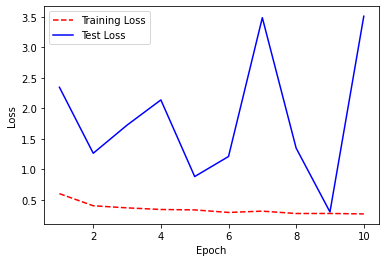

In [14]:
# # Plot the loss of training and validation for CNN
training_loss = history_cnn.history['loss']
epoch_count = range(1, len(training_loss) + 1)
test_loss = history_cnn.history['val_loss']
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

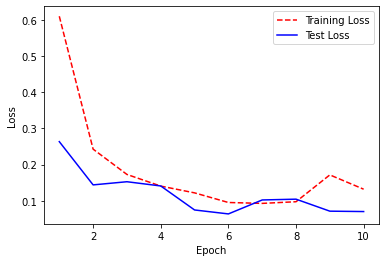

In [15]:
# # Plot the loss of training and validation for ANN
training_loss = history_dense.history['loss']
epoch_count = range(1, len(training_loss) + 1)
test_loss = history_dense.history['val_loss']
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')